In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['key_1.csv', 'train_1.csv', 'train_2.csv', 'key_2.csv', 'sample_submission_1.csv', 'sample_submission_2.csv']


In [26]:
import warnings
import scipy
from datetime import timedelta
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

## Load Data

In [3]:
path = Path('../input')

In [4]:
train = pd.read_csv(path/'train_1.csv')
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [5]:
train.shape

(145063, 551)

In [6]:
train_flattened = pd.melt(train[list(train.columns[-50:]) + ['Page']], id_vars='Page', var_name='date', value_name='Visits')
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')
train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)

In [7]:
train_flattened.head()

,Page,date,Visits,weekend
0,2NE1_zh.wikipedia.org_all-access_spider,2016-11-12,13.0,1.0
1,2PM_zh.wikipedia.org_all-access_spider,2016-11-12,12.0,1.0
2,3C_zh.wikipedia.org_all-access_spider,2016-11-12,6.0,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2016-11-12,38.0,1.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2016-11-12,13.0,1.0


### Median by Page

In [8]:
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']
df_mean = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']

train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median)

In [9]:
train_flattened.head()

,date,Visits,weekend,mean,median
Page,,,,,
!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.836735,2.0
!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.836735,2.0
!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.836735,2.0
!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.836735,2.0
!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.836735,2.0


In [10]:
train_flattened.reset_index(drop=False,inplace=True)

In [11]:
train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())

train_flattened['year'] = train_flattened.date.dt.year
train_flattened['month'] = train_flattened.date.dt.month
train_flattened['day'] = train_flattened.date.dt.day

In [12]:
train_flattened.head()

,Page,date,Visits,weekend,mean,median,weekday,year,month,day
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.836735,2.0,5,2016,11,12
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.836735,2.0,6,2016,11,13
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.836735,2.0,0,2016,11,14
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.836735,2.0,1,2016,11,15
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.836735,2.0,2,2016,11,16


### Visualization

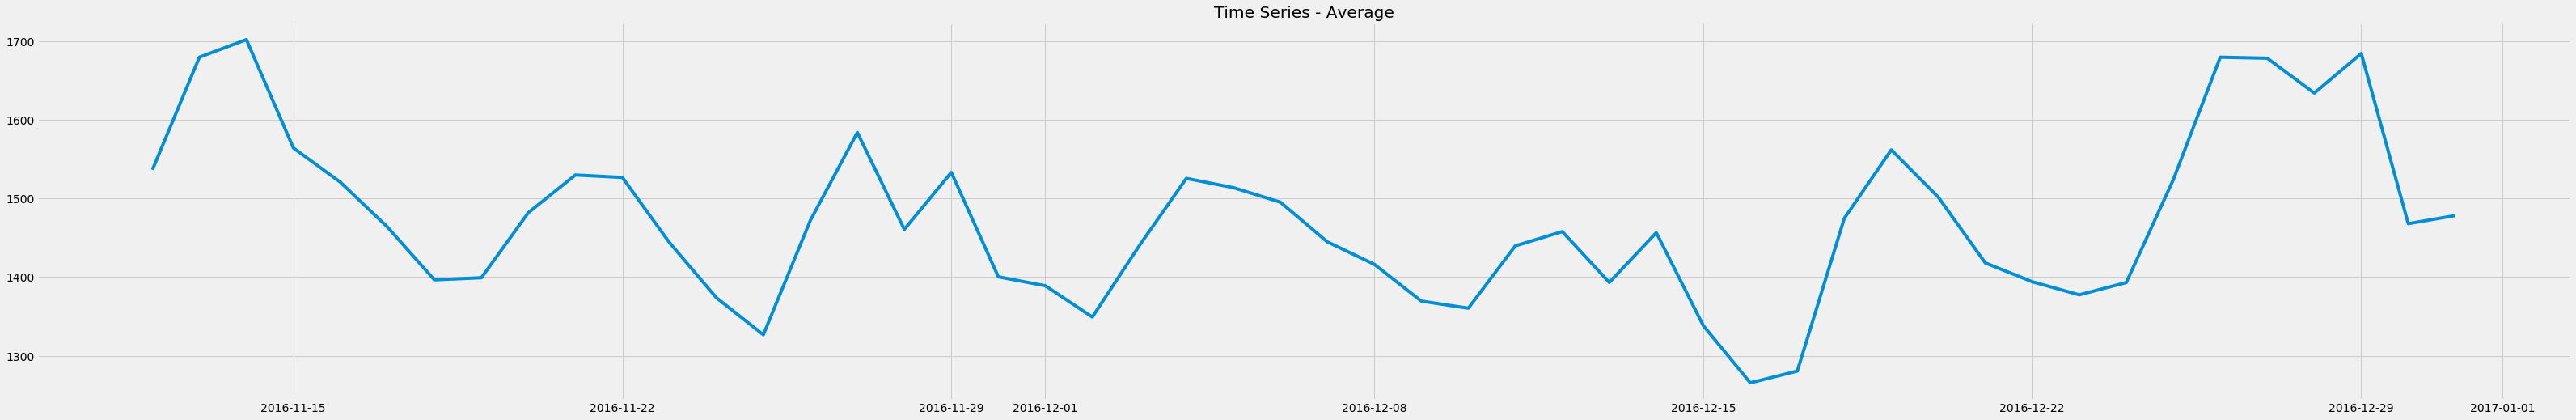

In [13]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page', 'date', 'Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

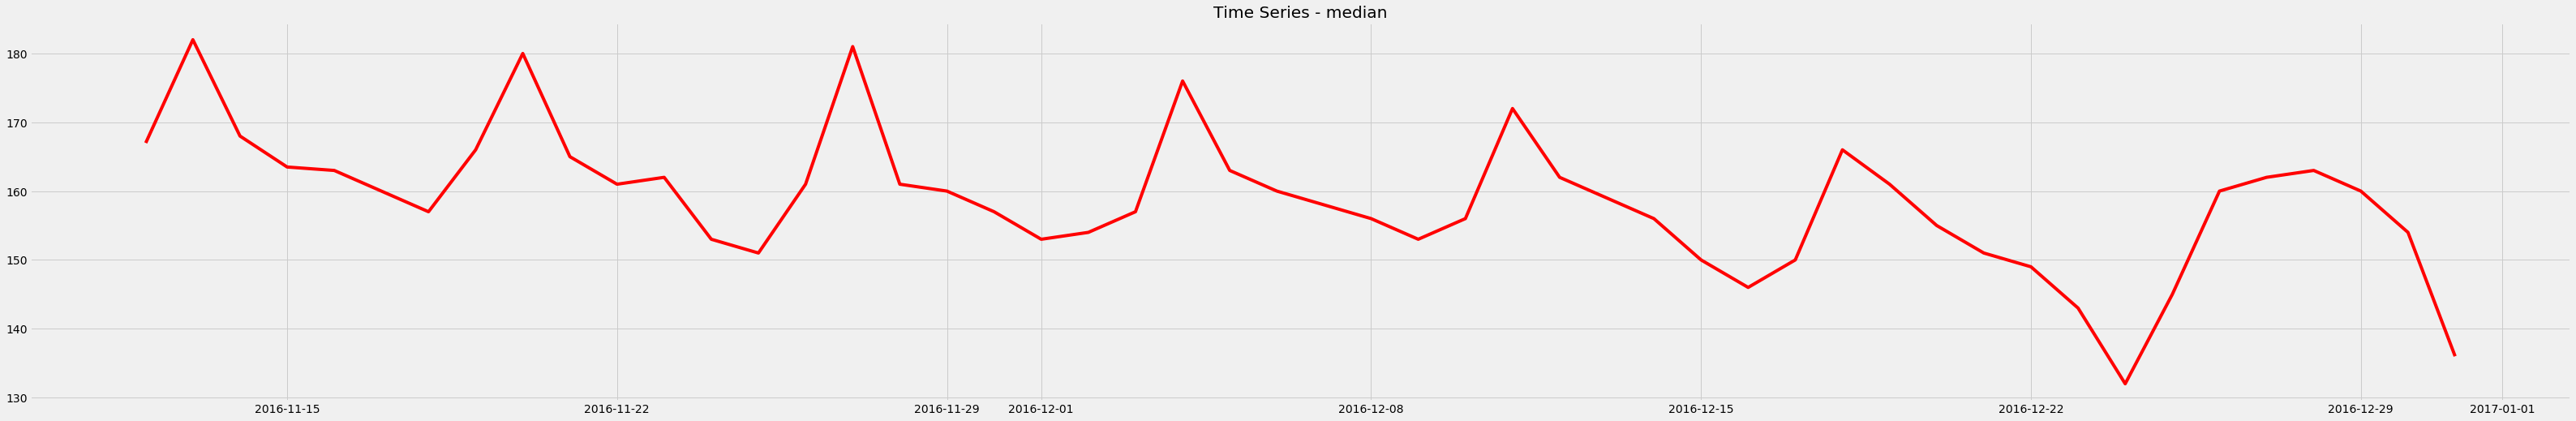

In [14]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page', 'date', 'Visits']].groupby(['date'])['Visits'].median()
plt.plot(mean_group, color='r')
plt.title('Time Series - median')
plt.show()

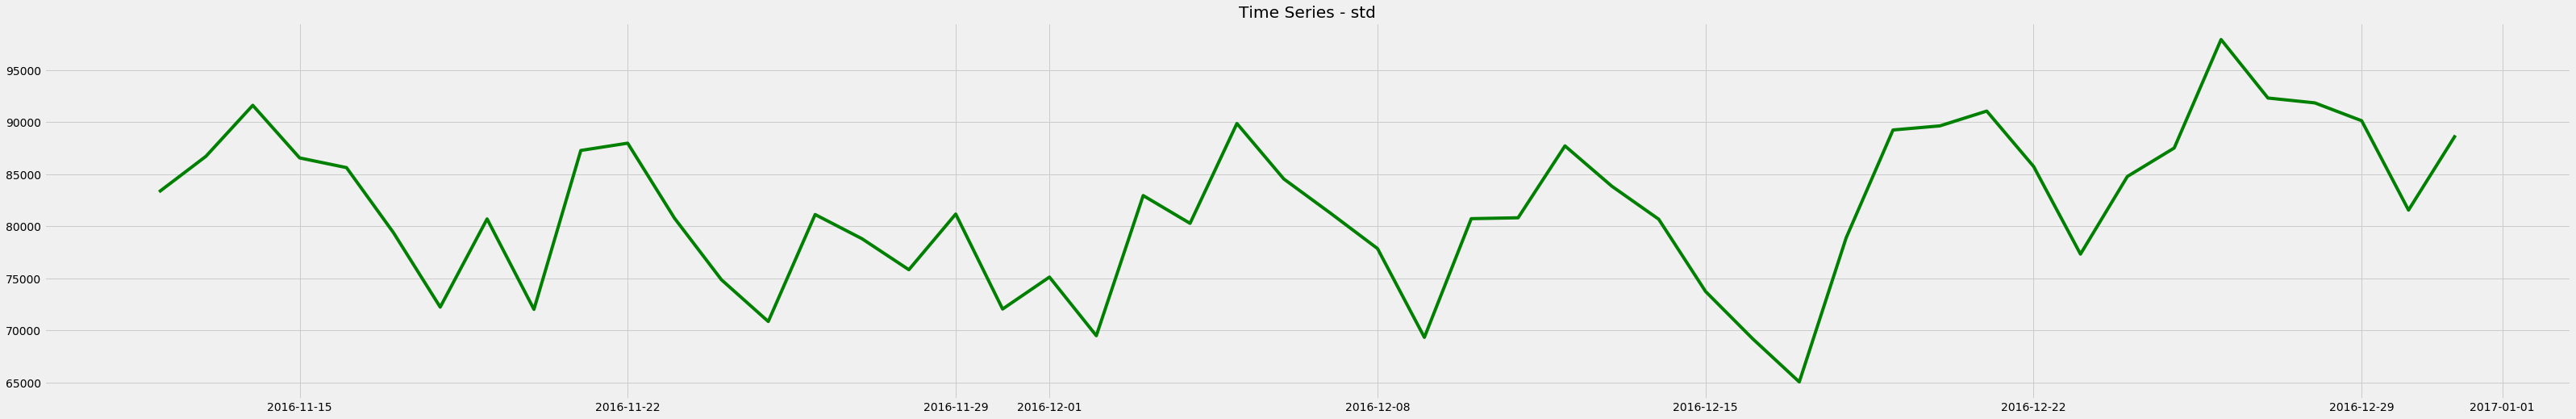

In [15]:
plt.figure(figsize=(50, 8))
std_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].std()
plt.plot(std_group, color = 'g')
plt.title('Time Series - std')
plt.show()

In [16]:
train_flattened['month_num'] = train_flattened['month']
train_flattened['month'].replace('11', '11 - November', inplace=True)
train_flattened['month'].replace('12', '12 - December', inplace=True)

train_flattened['weekday_num'] = train_flattened['weekday']
train_flattened['weekday'].replace(0, '01 - Monday', inplace=True)
train_flattened['weekday'].replace(1, '02 - Tuesday', inplace=True)
train_flattened['weekday'].replace(2, '03 - Wednesday', inplace=True)
train_flattened['weekday'].replace(3, '04 - Thursday', inplace=True)
train_flattened['weekday'].replace(4, '05 - Friday', inplace=True)
train_flattened['weekday'].replace(5, '06 - Saturday', inplace=True)
train_flattened['weekday'].replace(6, '07 - Sunday', inplace=True)

In [17]:
train_flattened.head()

,Page,date,Visits,weekend,mean,median,weekday,year,month,day,month_num,weekday_num
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.836735,2.0,06 - Saturday,2016,11,12,11,5
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.836735,2.0,07 - Sunday,2016,11,13,11,6
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.836735,2.0,01 - Monday,2016,11,14,11,0
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.836735,2.0,02 - Tuesday,2016,11,15,11,1
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.836735,2.0,03 - Wednesday,2016,11,16,11,2


In [18]:
train_group = train_flattened.groupby(["month", "weekday"])["Visits"].mean().reset_index()
train_group = train_group.pivot('weekday', 'month', 'Visits')
train_group.sort_index(inplace=True)

In [19]:
train_group.head()

month,11,12
weekday,,
01 - Monday,1564.058295,1553.219910
02 - Tuesday,1541.318249,1517.166439
03 - Wednesday,1454.986458,1488.305696
04 - Thursday,1418.773382,1444.474767
05 - Friday,1361.625633,1365.955630


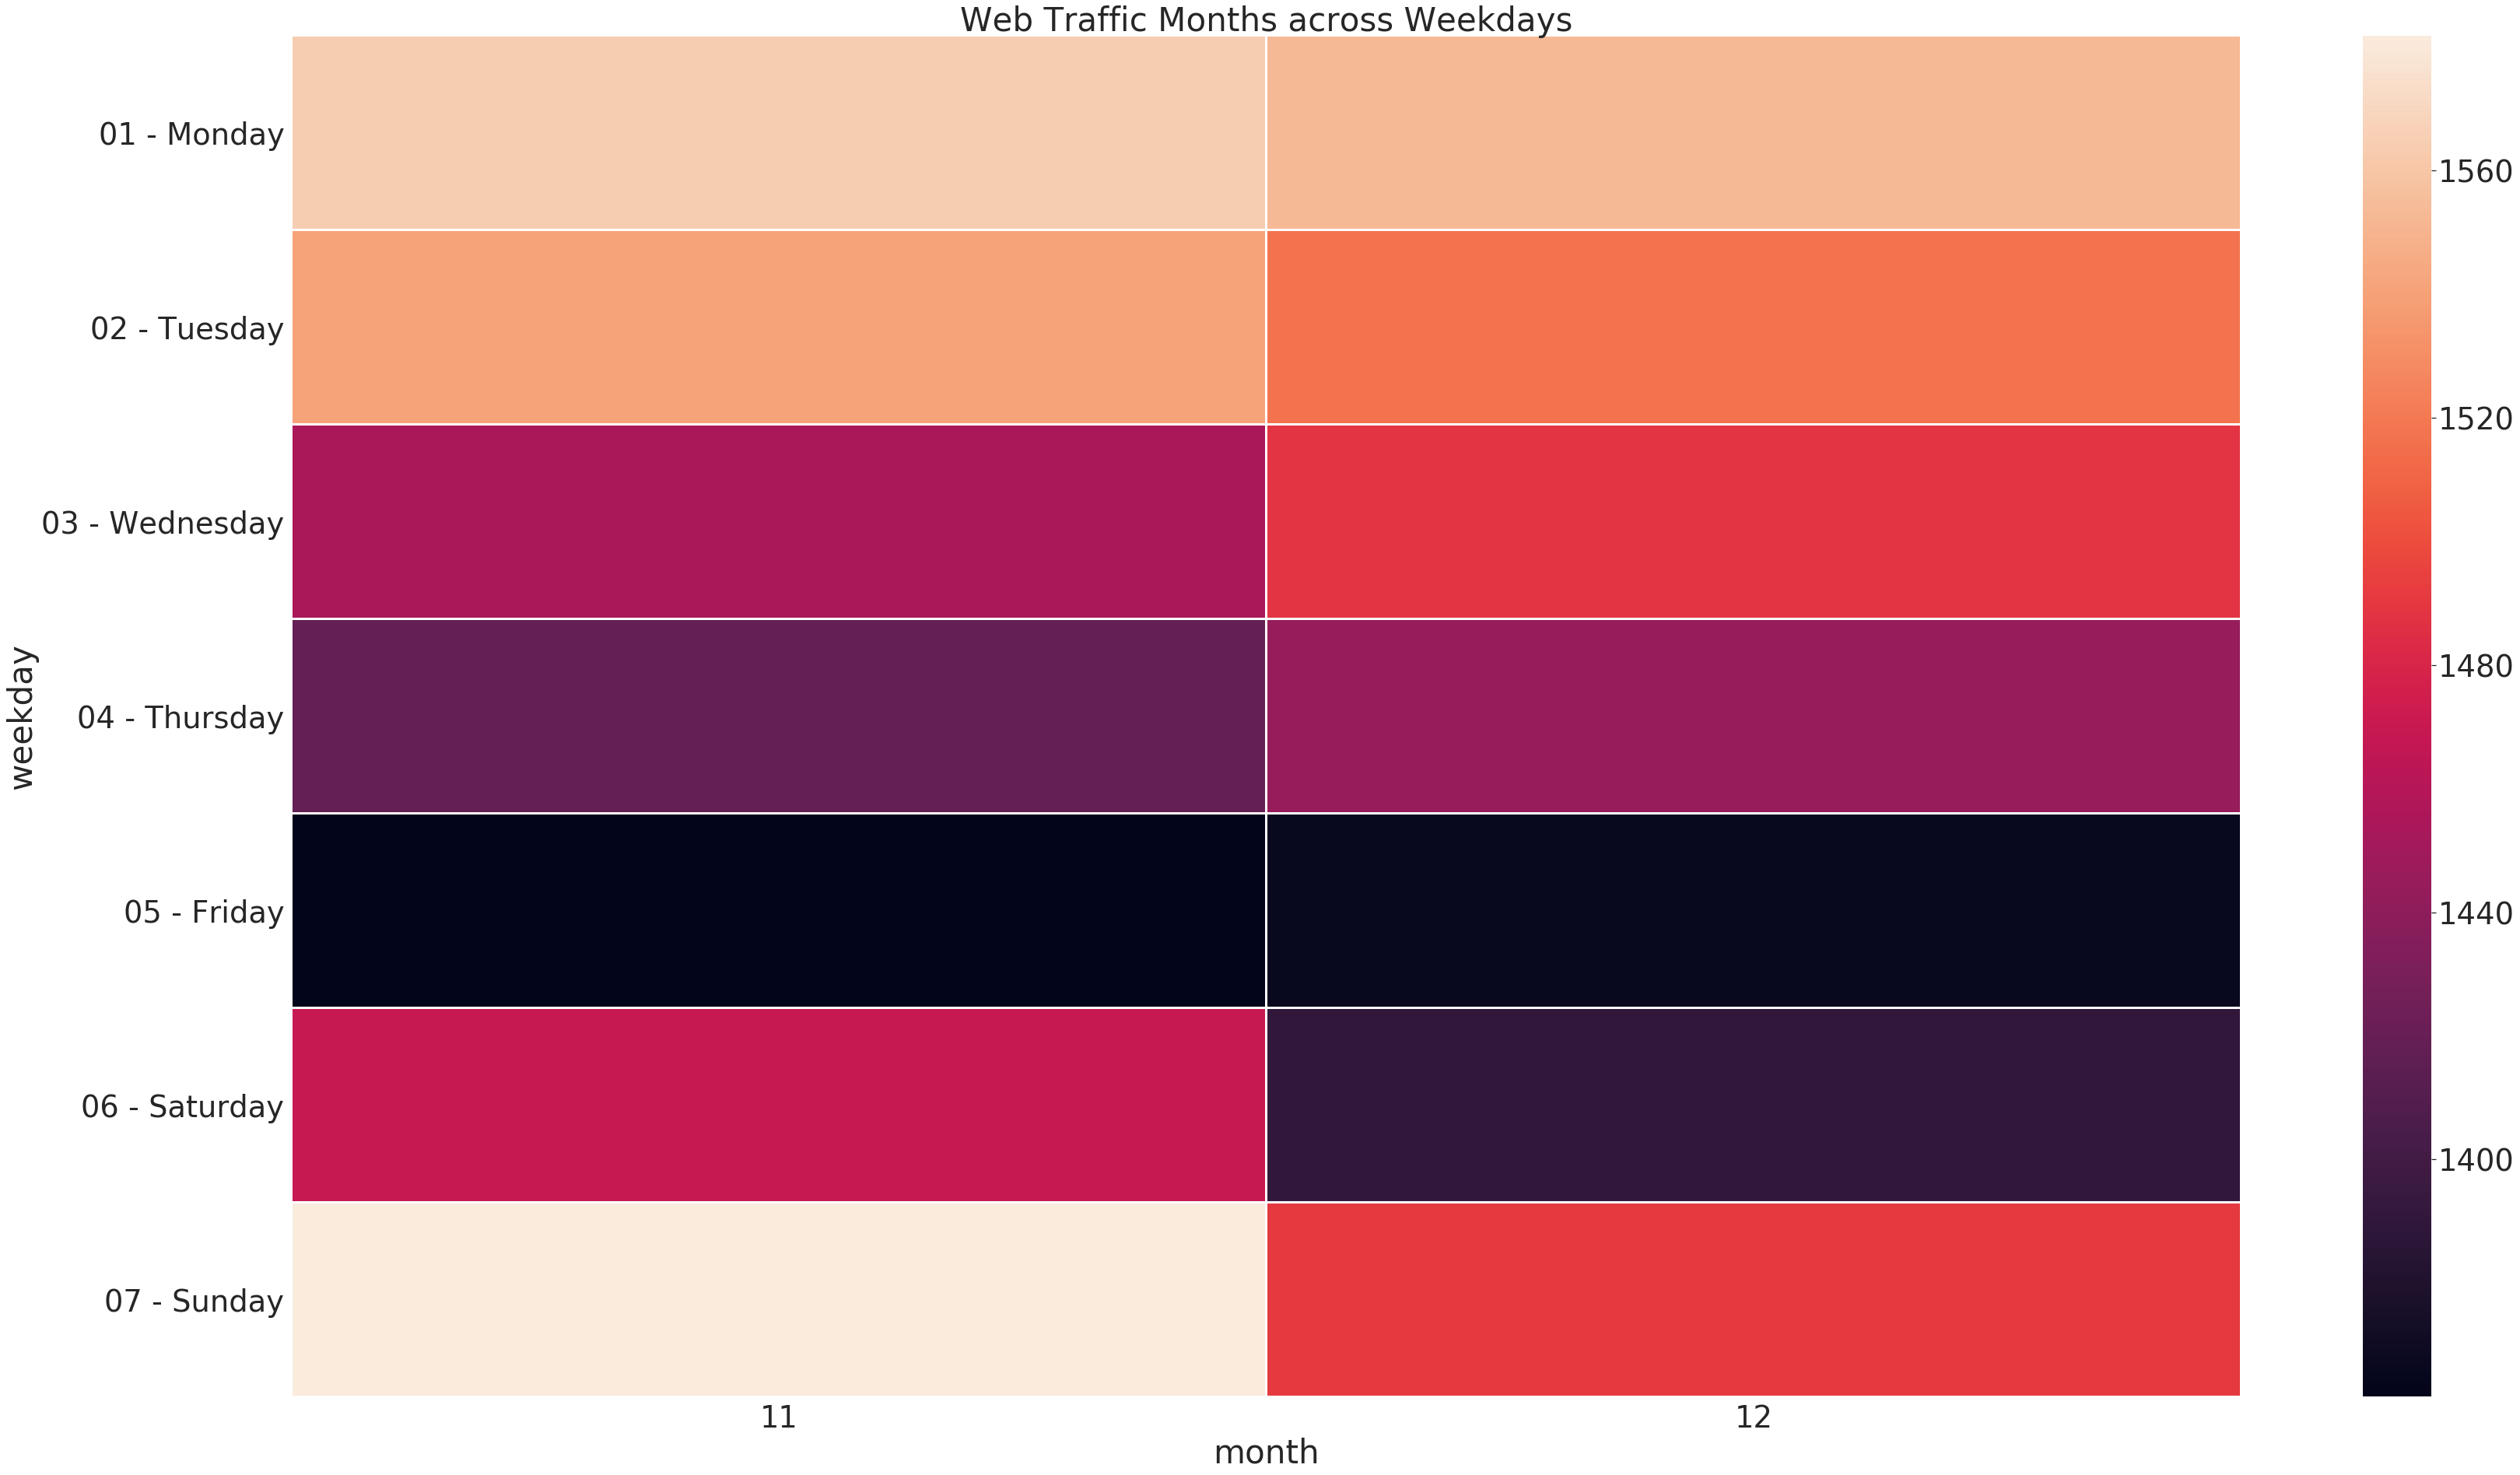

In [20]:
sns.set(font_scale=3.5)

f, ax = plt.subplots(figsize=(50, 30))

sns.heatmap(train_group, annot=False, ax=ax, fmt='d', linewidths=2)
plt.title('Web Traffic Months across Weekdays')
plt.show()

In [21]:
train_day = train_flattened.groupby(['month', 'day'])['Visits'].mean().reset_index()
train_day = train_day.pivot('day', 'month', 'Visits')
train_day.sort_index(inplace=True)
train_day.dropna(inplace=True)

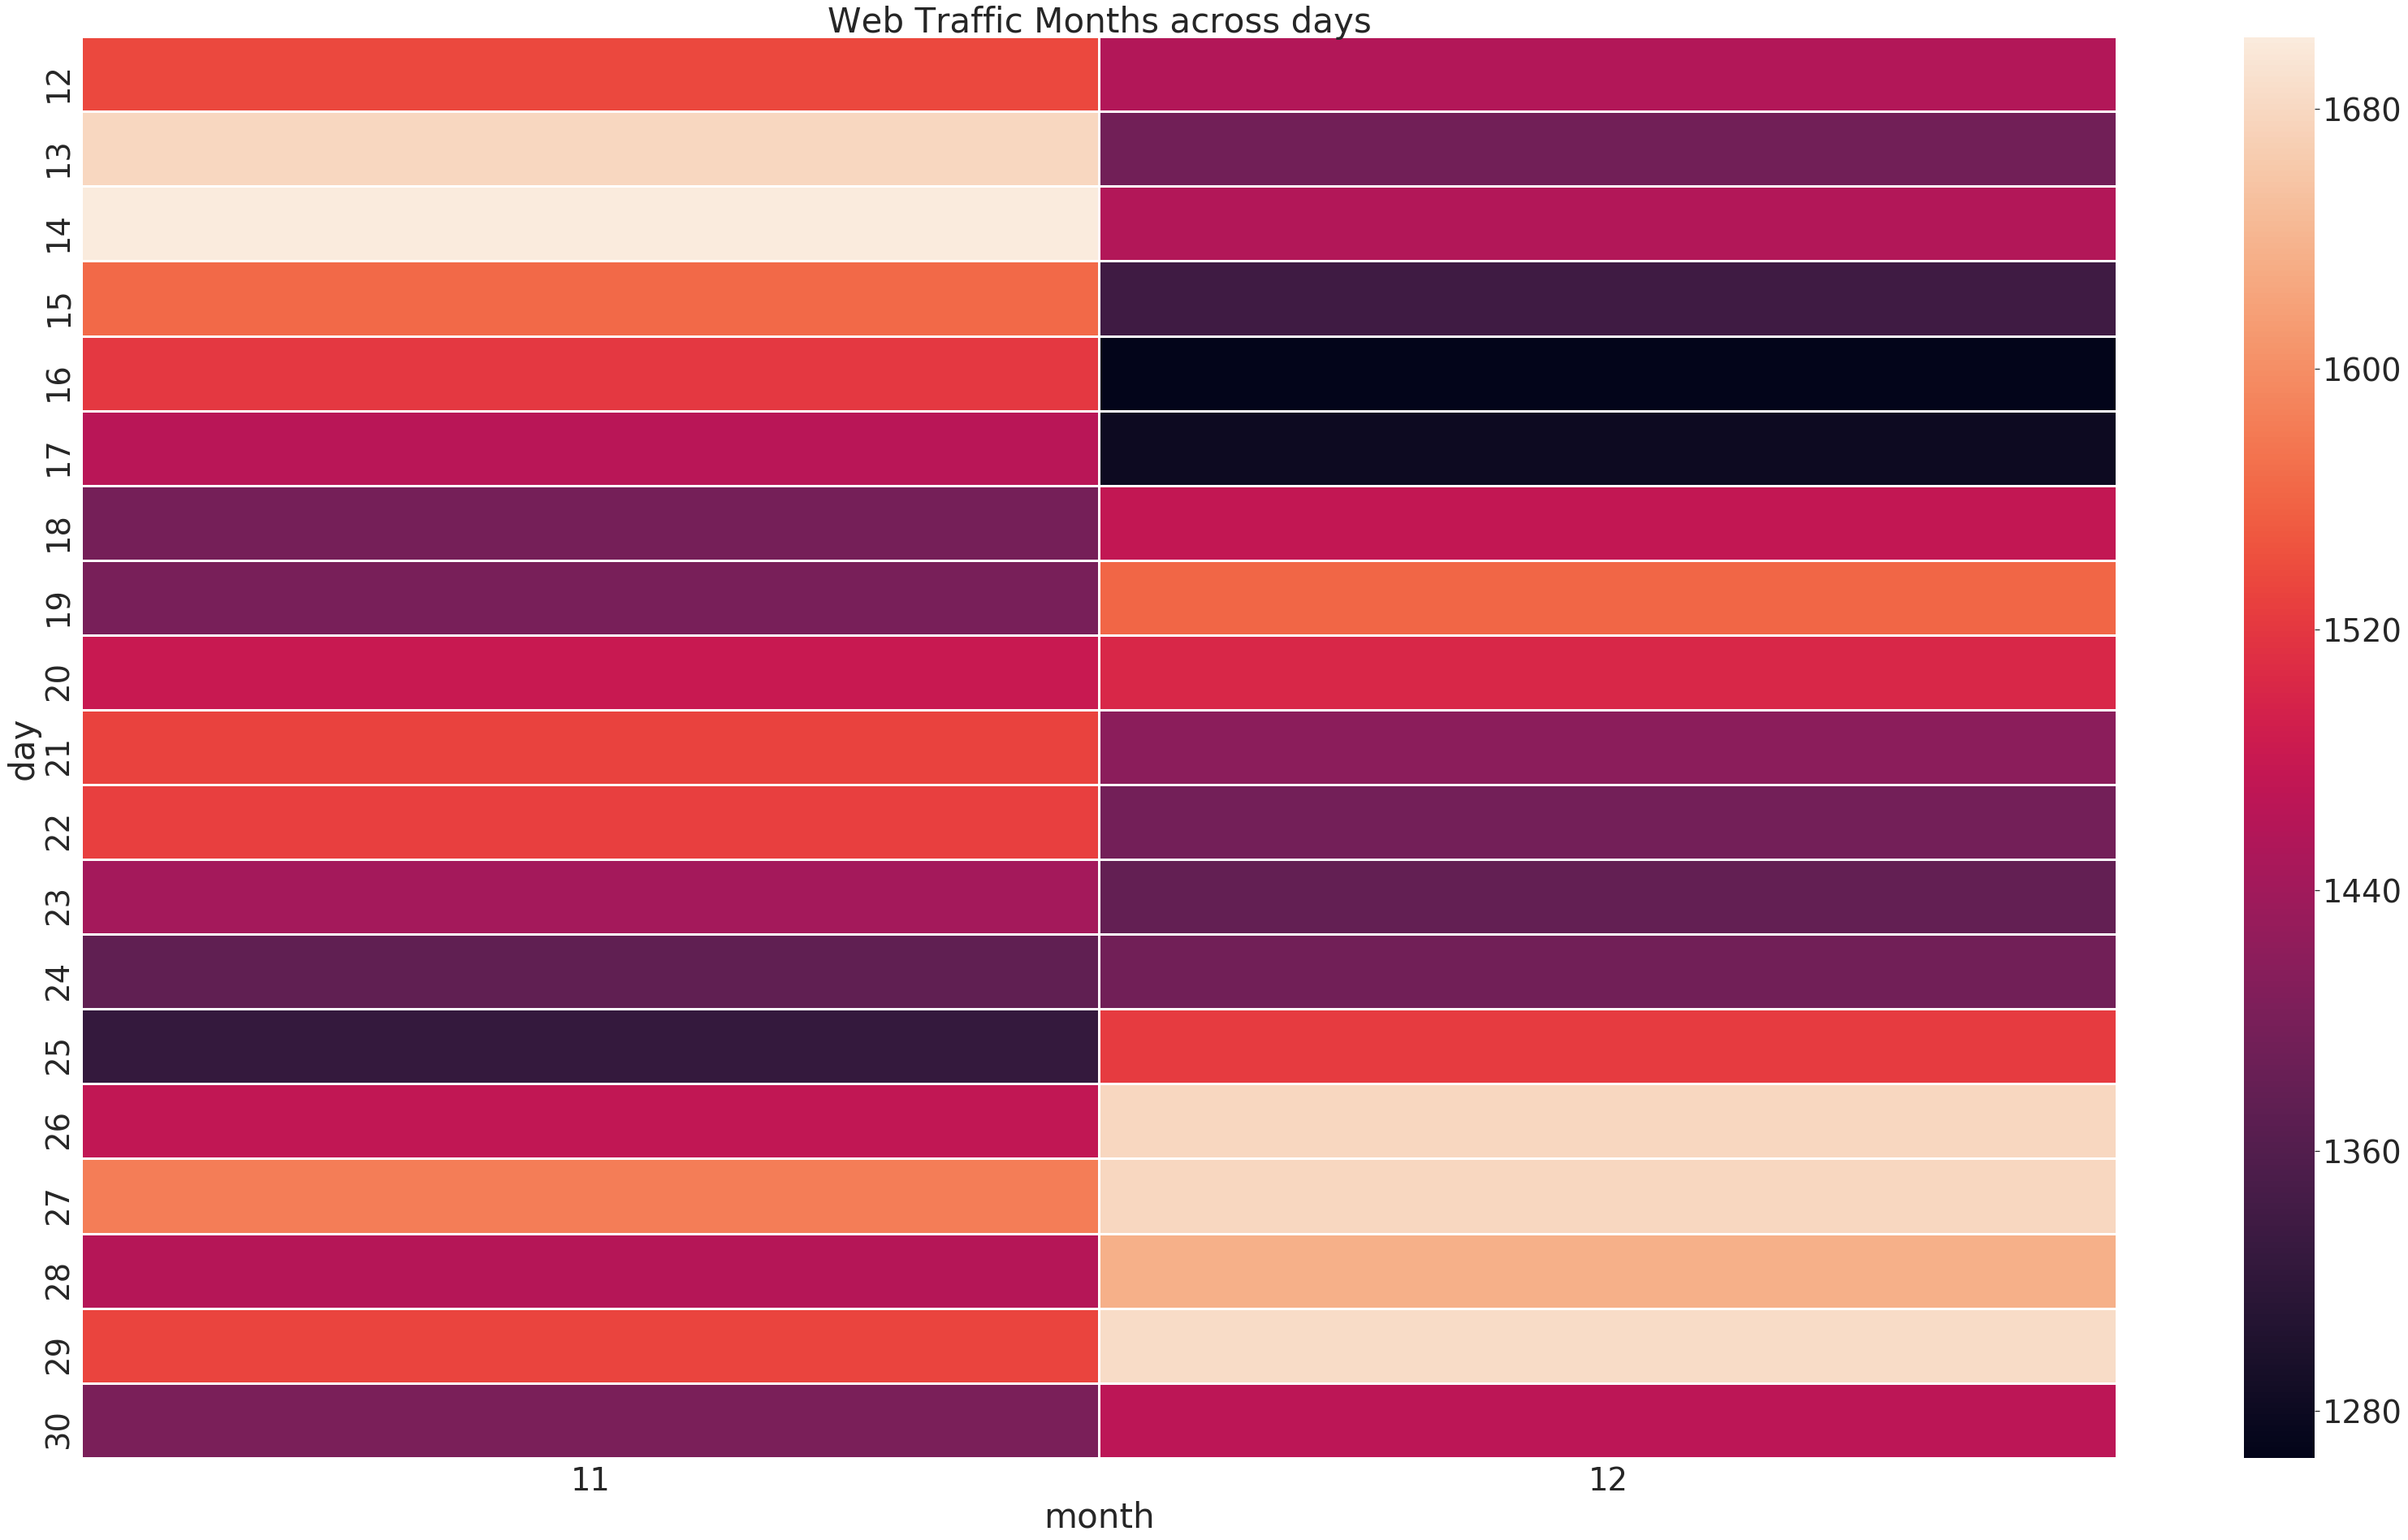

In [22]:
f, ax = plt.subplots(figsize=(50, 30))

sns.heatmap(train_day, annot=False, ax=ax, fmt='d', linewidths=2)
plt.title('Web Traffic Months across days')
plt.show()

### ML Approach

In [23]:
times_series_means = pd.DataFrame(mean_group).reset_index(drop=False)
times_series_means['weekday'] = times_series_means['date'].apply(lambda x: x.weekday())
times_series_means['Date_str'] = times_series_means['date'].apply(lambda x: str(x))
times_series_means[['year', 'month', 'day']] = pd.DataFrame(times_series_means['Date_str'].str.split('-', 2).tolist(), columns = ['year','month','day'])
date_staging = pd.DataFrame(times_series_means['day'].str.split(' ', 2).tolist(), columns=['day', 'other'])
times_series_means['day'] = date_staging['day'] * 1
times_series_means.drop('Date_str',axis = 1, inplace =True)
times_series_means.head()

,date,Visits,weekday,year,month,day
0,2016-11-12,167.0,5,2016,11,12
1,2016-11-13,182.0,6,2016,11,13
2,2016-11-14,168.0,0,2016,11,14
3,2016-11-15,163.5,1,2016,11,15
4,2016-11-16,163.0,2,2016,11,16


In [28]:
times_series_means.reset_index(drop=True,inplace=True)

def lag_func(data, lag):
    lag = lag
    X = lagmat(data['diff'], lag)
    lagged = data.copy()
    for c in range(1, lag+1):
        lagged["lag%d" % c] = X[:, c-1]
    return lagged

def diff_creation(data):
    data["diff"] = np.nan
    data.ix[1:, "diff"] = (data.iloc[1:, 1].as_matrix() - data.iloc[:len(data)-1, 1].as_matrix())
    return data

df_count = diff_creation(times_series_means)

lag = 7
lagged = lag_func(df_count,lag)
last_date = lagged['date'].max()

In [29]:
lagged.head()

,date,Visits,weekday,year,month,day,diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7
0,2016-11-12,167.0,5,2016,11,12,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-11-13,182.0,6,2016,11,13,15.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-11-14,168.0,0,2016,11,14,-14.0,15.0,NaN,0.0,0.0,0.0,0.0,0.0
3,2016-11-15,163.5,1,2016,11,15,-4.5,-14.0,15.0,NaN,0.0,0.0,0.0,0.0
4,2016-11-16,163.0,2,2016,11,16,-0.5,-4.5,-14.0,15.0,NaN,0.0,0.0,0.0


In [30]:
def train_test(data_lag):
    xc = ["lag%d" % i for i in range(1, lag+1)] + ['weekday'] + ['day']
    split = 0.7
    xt = data_lag[(lag+1):][xc]
    yt = data_lag[(lag+1):]['diff']
    isplit = int(len(xt) * split)
    x_train, y_train, x_test, y_test = xt[:isplit], yt[:isplit], xt[isplit:], yt[isplit:]
    return x_train, y_train, x_test, y_test, xt, yt

x_train, y_train, x_test, y_test, xt, yt = train_test(lagged)

In [31]:
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [33]:
def modelisation(x_tr, y_tr, x_ts, y_ts, xt, yt, model0, model1):
    model0.fit(x_tr, y_tr)
    prediction = model0.predict(x_ts)
    r2 = r2_score(y_ts.as_matrix(), model0.predict(x_ts))
    mae = mean_absolute_error(y_ts.as_matrix(), model0.predict(x_ts))
    print ("-----------------------------------------------")
    print ("mae with 70% of the data to train:", mae)
    print ("-----------------------------------------------")

    model1.fit(xt, yt) 
    return model1, prediction, model0

model0 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)
model1 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

clr, prediction, clr0 = modelisation(x_train, y_train, x_test, y_test, xt, yt, model0, model1)

-----------------------------------------------
mae with 70% of the data to train: 8.112912087912088
-----------------------------------------------
